In [1]:
from helperFunctions import *

In [2]:

df = pd.read_csv('./ml_task_data.csv')
df['CompletionDate'] = pd.to_datetime(df.CompletionDate)
df['CompletionDate'] = df['CompletionDate'].dt.strftime('%Y')

df['SpudDate'] = pd.to_datetime(df.SpudDate)
df['SpudDate'] = df['SpudDate'].dt.strftime('%Y')

df.dropna(how='all', subset=['SpudDate', 'CompletionDate'], inplace=True)

In [3]:

basin_compdate_grouped = df.groupby(["Basin", "CompletionDate"])
basin_grouped = df.groupby(["Basin"])
state_grouped = df.groupby(["State"])
spud_date_grouped = df.groupby(['SpudDate'])


In [4]:

for key, item in spud_date_grouped:
    df.loc[(df['SpudDate'] == key), 'CompletionDate'] = item['CompletionDate'].fillna(item['CompletionDate'].mode()[0])


In [5]:

for key, item in state_grouped:
    state = key
    basin_mode = item["Basin"].mode()[0]
    df.loc[(df["State"] == state), "Basin"] = item["Basin"].fillna(basin_mode)
    

In [6]:
for key, item in basin_grouped:
    basin = key
    state_mode = item["State"].mode()[0]
    df.loc[(df["Basin"] == basin), "State"] = item["State"].fillna(state_mode)
    df.loc[(df["Basin"] == basin), "Latitude"] = item["Latitude"].fillna(item["Latitude"].median())
    df.loc[(df["Basin"] == basin), "Longitude"] = item["Longitude"].fillna(item["Longitude"].median())



In [7]:

for key, item in basin_compdate_grouped:
    basin = key[0]
    compdate = key[1]

    bvhh_median = item["BVHH"].median()
    lat_length_in_miles_median = item['LateralLengthInMiles'].median()

    if math.isnan(bvhh_median):
        bvhh_median = df.loc[(df["Basin"] == basin)]["BVHH"].median()
    
    if math.isnan(bvhh_median):
        bvhh_median = df.loc[(df["CompletionDate"] == compdate)]["BVHH"].median()
    
    if math.isnan(bvhh_median):
        bvhh_median = df["BVHH"].median()

    if math.isnan(bvhh_median):
        bvhh_median = 1


    if math.isnan(lat_length_in_miles_median):
        lat_length_in_miles_median = df.loc[(df["Basin"] == basin)]["LateralLengthInMiles"].median()
    
    if math.isnan(lat_length_in_miles_median):
        lat_length_in_miles_median = df.loc[(df["CompletionDate"] == compdate)]["LateralLengthInMiles"].median()
    
    if math.isnan(lat_length_in_miles_median):
        lat_length_in_miles_median = df["LateralLengthInMiles"].median()

    if math.isnan(lat_length_in_miles_median):
        lat_length_in_miles_median = 0.75

    
    # Updating bvhh nan values
    df.loc[(df["Basin"] == basin) & (df["CompletionDate"] == compdate), "BVHH"] = item['BVHH'].fillna(bvhh_median)

    # Updating LateralLengthInMiles nan values
    df.loc[(df["Basin"] == basin) & (df["CompletionDate"] == compdate), "LateralLengthInMiles"] = item['LateralLengthInMiles'].fillna(lat_length_in_miles_median)
    


In [8]:
state_grouped = df.groupby(["State"])

for key, item in state_grouped:
    state = key
    
    formation_alias_mode_arr = item['formationAlias'].mode()
    
    if len(formation_alias_mode_arr) == 0: # check if mode is nan
        formation_alias_mode_arr = df["formationAlias"].mode()

    df.loc[(df['State'] == state), 'formationAlias'] = item['formationAlias'].fillna(formation_alias_mode_arr[0])


In [9]:

df['OperatorAlias'] = df['OperatorAlias'].fillna(df['OperatorAlias'].mode()[0])


In [10]:
df.dropna(inplace=True)

In [11]:
df['CompletionDate'] = df['CompletionDate'].astype(int)
df['SpudDate'] = df['SpudDate'].astype(int)

In [12]:
print(df['proppantPerFoot'].count())

50554


In [78]:
X_train, X_test, Y_train, Y_test = generate_train_test(df, xcolumns=['State', 'Latitude', 'Longitude', 'OperatorAlias', 'formationAlias', 'CompletionDate', 'SpudDate'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.one_hot_encoding, normalized=True, test_size=0.15)

In [94]:

model = RandomForestRegressor(n_estimators=100, max_features=7)
model.fit(X_train, Y_train)


RandomForestRegressor(max_features=7)

In [95]:
y_pred = model.predict(X_test)

In [96]:
# print(y_pred.mean(), Y_test.mean())
ytest_list = Y_test.to_list()
for i in range(1,21):
    print(ytest_list[i], y_pred[i])
# print(y_pred[:20])
# print(Y_test.to_list()[:20])

889.6354410202 790.2380409513099
2623.4301481266 2464.2554900019786
2347.400118087 2304.9286919204897
489.74564926370005 664.0774169539931
1818.9520491803 1698.83932244236
1868.9515498044 1901.597364082058
148.7433461538 143.125028620296
1947.761234826 2248.0550326327457
1843.9321010383999 1707.9537779931159
510.6279296875 576.5443298916903
182.4777107261 206.08430112429286
1245.3460157236 1252.0169220437415
677.8922102346 1371.3845004854663
2620.6892280469 2544.609164313362
374.7523799337 438.6604759659578
808.2947830102 620.1560900911188
1308.9452153541001 1294.4248779499574
1385.9701472909 1758.562152092709
1997.000656168 1988.727131493887
755.7290569651 848.3262530505901


In [97]:
r2_score(y_true=ytest_list, y_pred=y_pred)

0.8341598655548368

In [98]:

mean_squared_error(ytest_list,y_pred, squared=False)


320.6327916166788

In [99]:

print(np.median(ytest_list), np.median(y_pred))


1109.4356107030999 1121.026581799324


Mean squared errors avg = 331.9572248559152
R2 Score avg = 0.8253590086665591


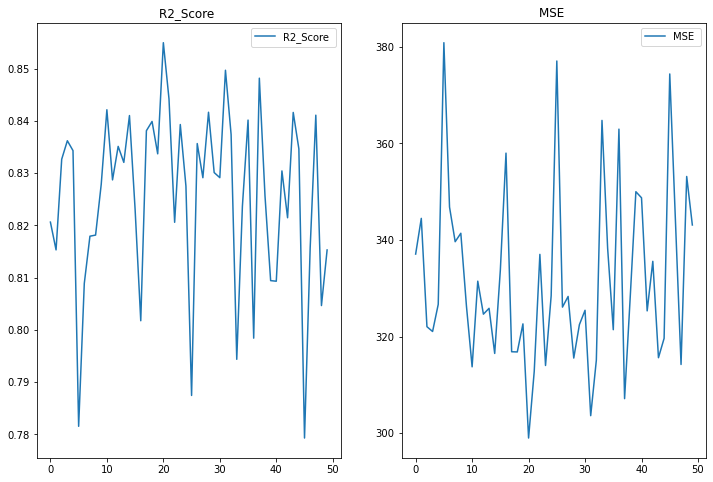

In [62]:
plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'OperatorAlias', 'formationAlias', 'CompletionDate', 'SpudDate'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=True, test_size=0.15, runtimes=50)

Mean squared errors avg = 348.6945124607427
R2 Score avg = 0.8088956154205909


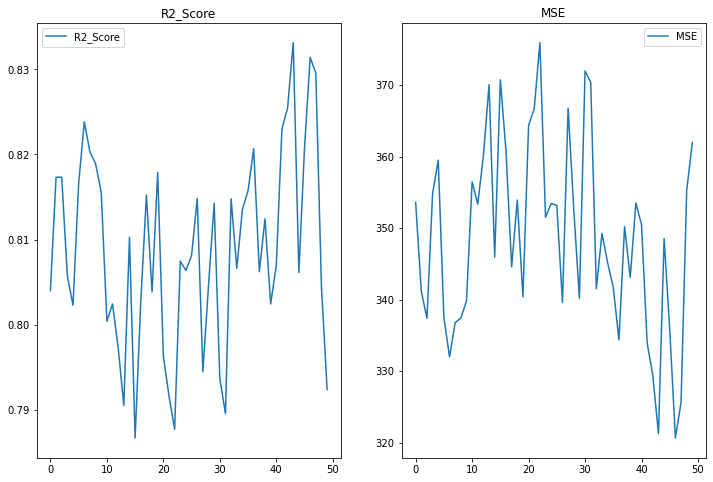

In [20]:

plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'formationAlias', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=50)


Mean squared errors avg = 336.04232862017943
R2 Score avg = 0.8220390457111477


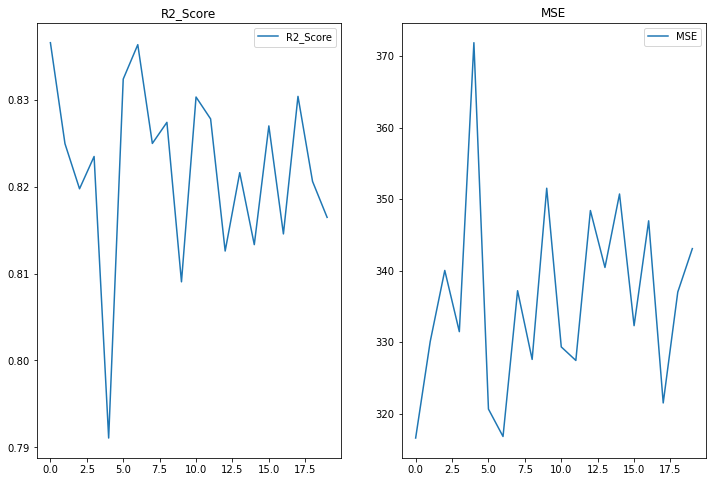

In [20]:
plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'OperatorAlias', 'formationAlias', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=20)


Mean squared errors avg = 337.83254084990483
R2 Score avg = 0.8204528593290332


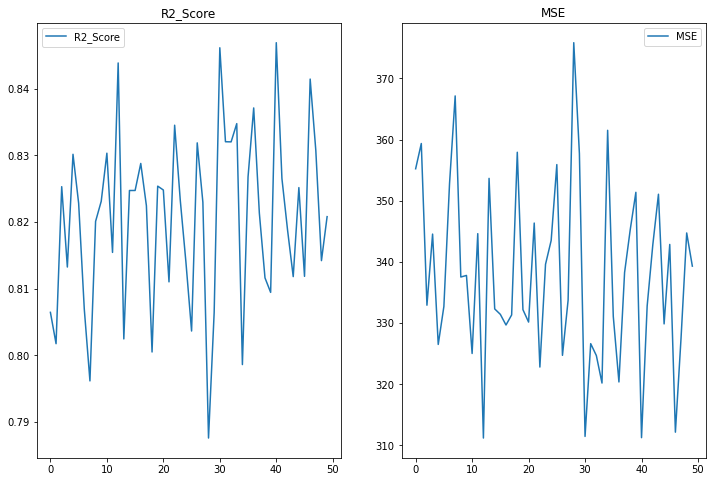

In [22]:
plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'OperatorAlias', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=50)

Mean squared errors avg = 333.72244627461805
R2 Score avg = 0.8246873865516772


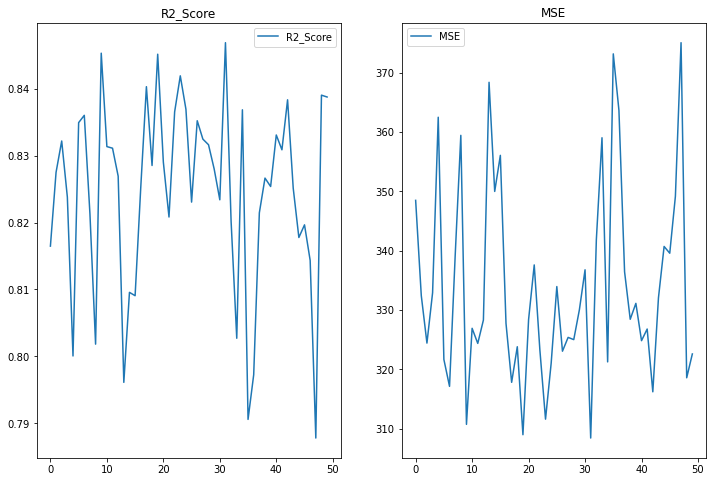

In [23]:

plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'OperatorAlias', 'formationAlias', 'Basin', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=50)


Mean squared errors avg = 345.27950072979615
R2 Score avg = 0.8119942465188007


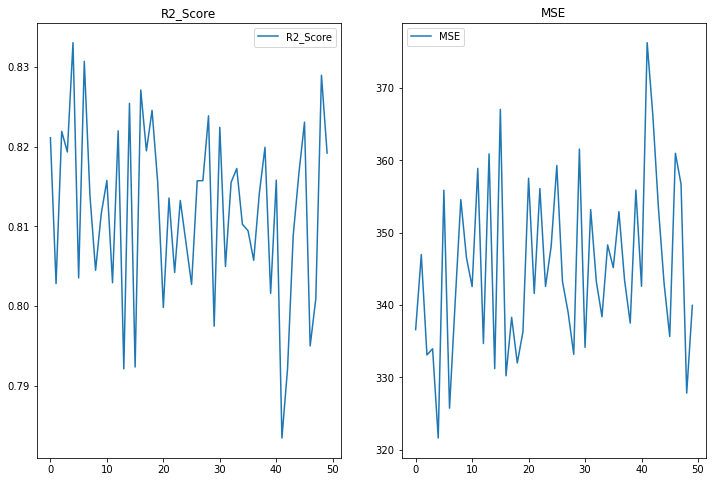

In [24]:

plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'formationAlias', 'BVHH', 'CompletionDate', 'SpudDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=50)


Mean squared errors avg = 330.7672628529828
R2 Score avg = 0.8265642705697657


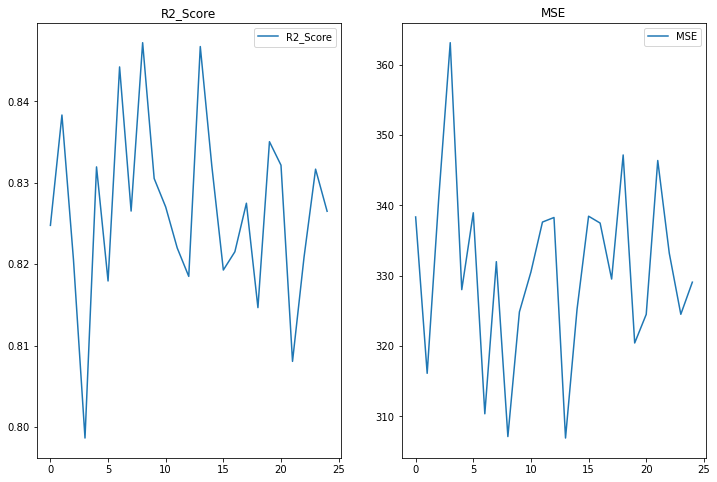

In [25]:



plot_metrics(df, xcolumns=['State', 'Basin', 'Latitude', 'Longitude', 'BVHH', 'OperatorAlias', 'formationAlias', 'CompletionDate', 'SpudDate', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=25)


In [37]:

test_lis = ['1', '9', '4', '2', '0', '10']
for i in range(len(test_lis)):
    test_lis_copy = test_lis.copy()
    test_lis_copy.remove(test_lis_copy[i])
    print(test_lis_copy)


['9', '4', '2', '0', '10']
['1', '4', '2', '0', '10']
['1', '9', '2', '0', '10']
['1', '9', '4', '0', '10']
['1', '9', '4', '2', '10']
['1', '9', '4', '2', '0']


Mean squared errors avg = 273.93809737640817
R2 Score avg = 0.8499327971137806


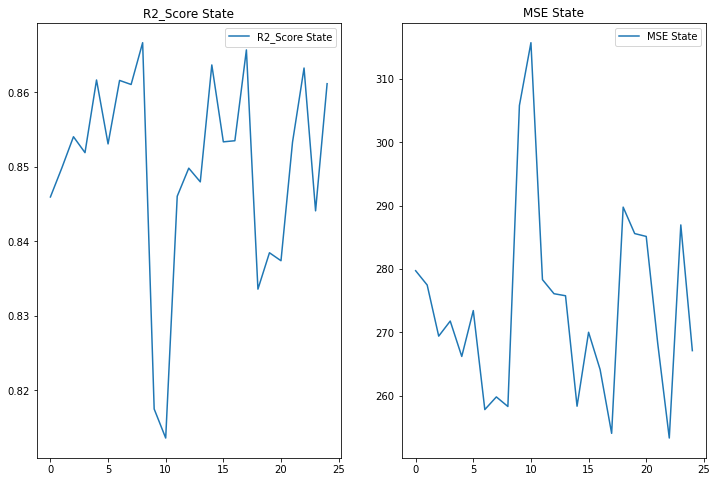

Mean squared errors avg = 278.4176523416296
R2 Score avg = 0.8453205237266846


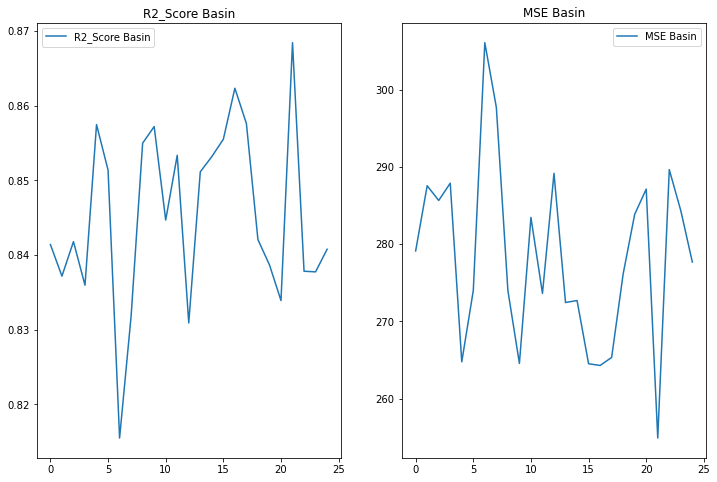

Mean squared errors avg = 277.55749657070123
R2 Score avg = 0.8446394312659735


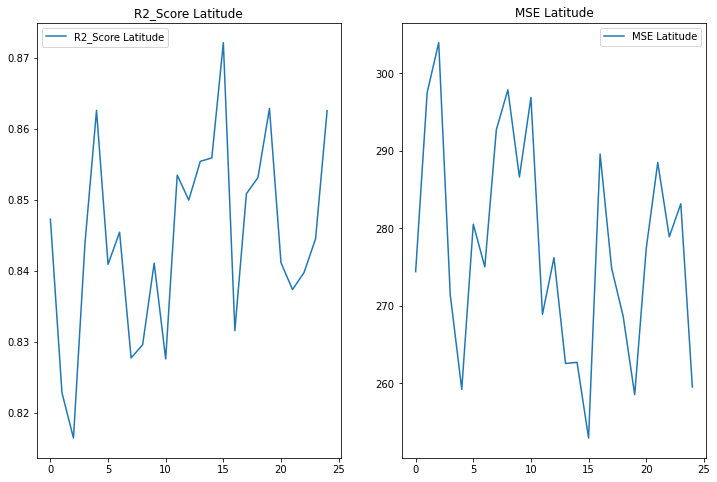

Mean squared errors avg = 280.53891343774467
R2 Score avg = 0.8420616543165077


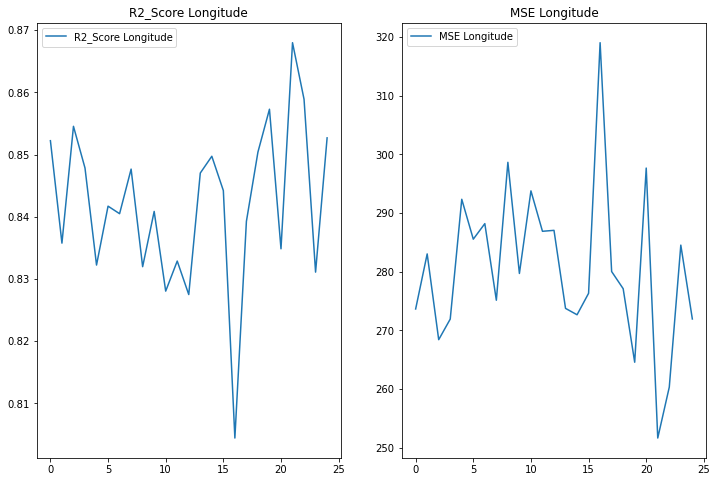

Mean squared errors avg = 270.24411627157065
R2 Score avg = 0.8527392388225402


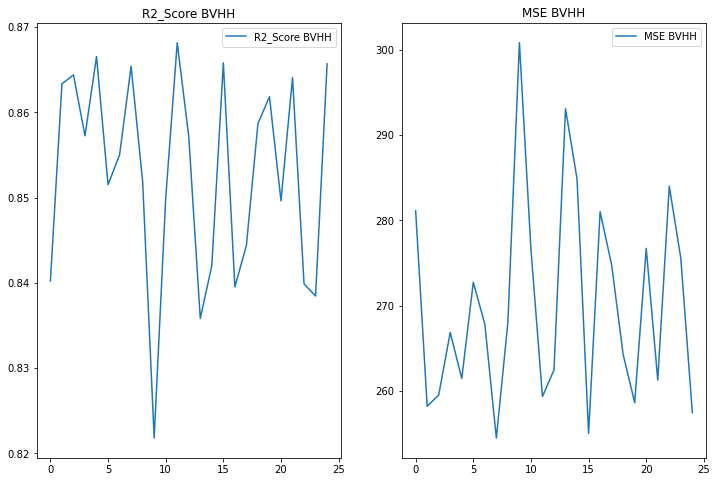

Mean squared errors avg = 288.8895105346021
R2 Score avg = 0.8302596125966488


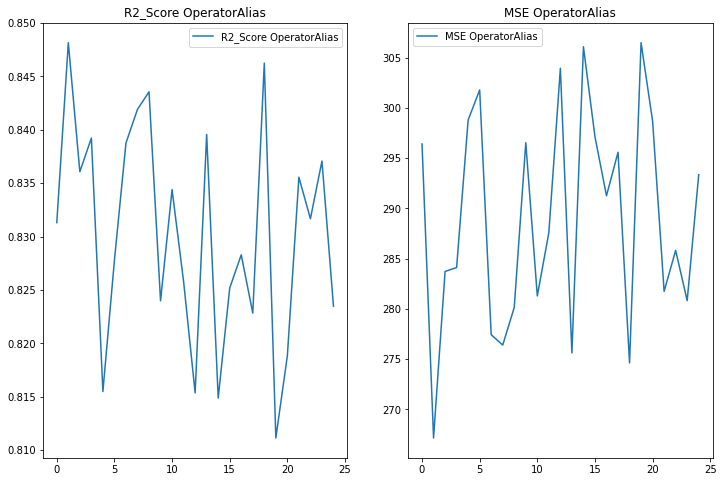

Mean squared errors avg = 275.3909578414039
R2 Score avg = 0.8473548452337709


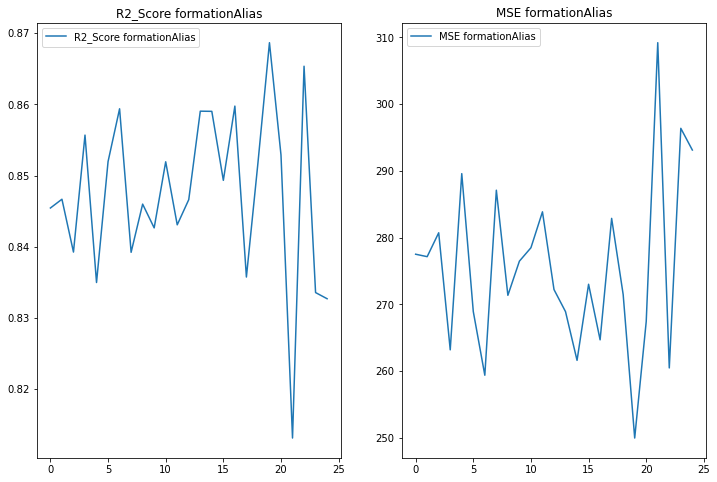

Mean squared errors avg = 282.8798114494277
R2 Score avg = 0.8403537857526905


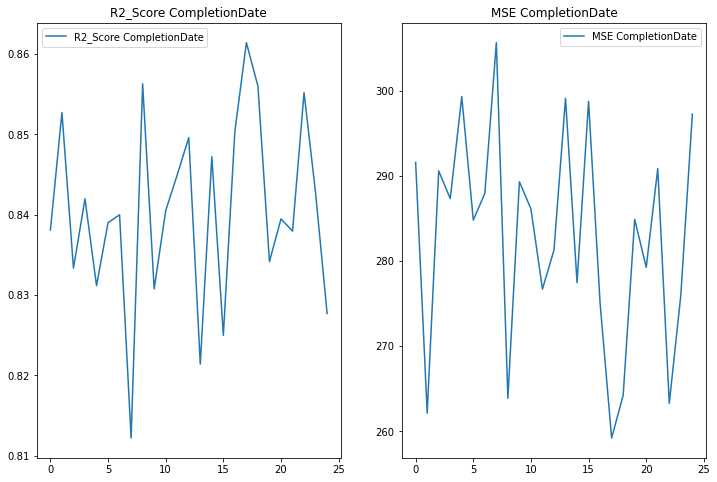

Mean squared errors avg = 281.05778431347744
R2 Score avg = 0.8433449286075052


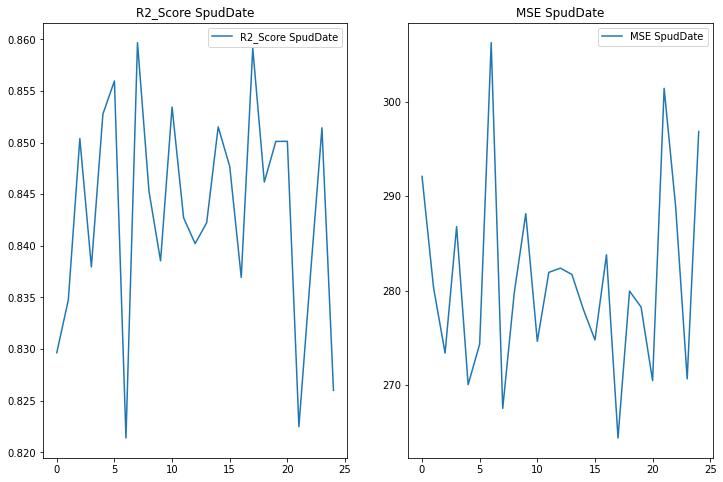

Mean squared errors avg = 274.5070052289855
R2 Score avg = 0.8481569618947924


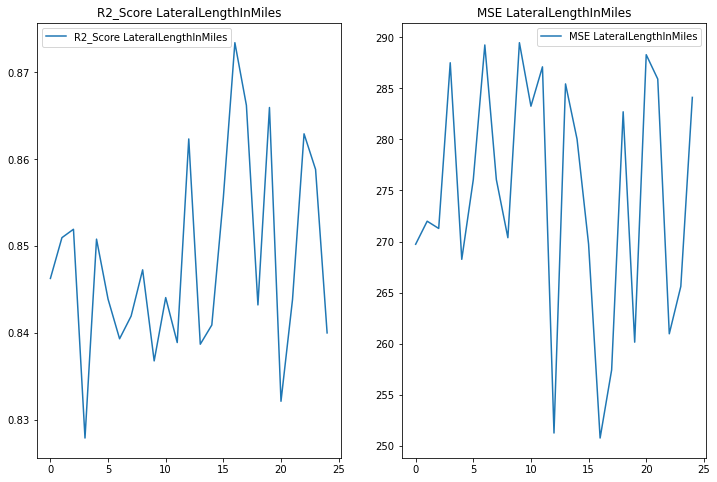

In [8]:

all_cols = ['State', 'Basin', 'Latitude', 'Longitude', 'BVHH', 'OperatorAlias', 'formationAlias', 'CompletionDate', 'SpudDate', 'LateralLengthInMiles']
for i in range(len(all_cols)):
    all_cols_copy = all_cols.copy()
    title_suffix = all_cols_copy[i]
    all_cols_copy.remove(all_cols_copy[i])
    plot_metrics(df, xcolumns=all_cols_copy, ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=25, title_suffix=title_suffix)


Mean squared errors avg = 334.5173968794491
R2 Score avg = 0.8237004086212236


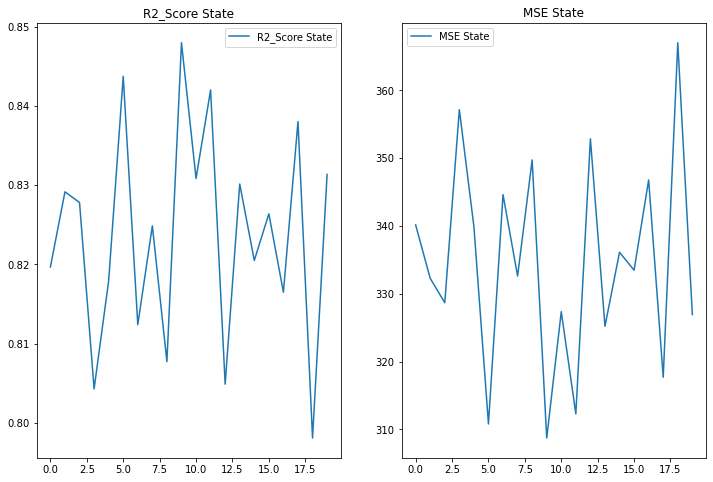

Mean squared errors avg = 342.1372015705195
R2 Score avg = 0.8148102359793065


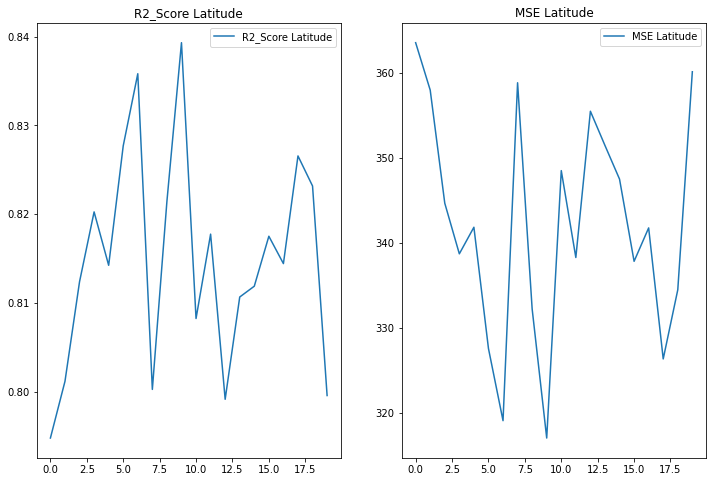

Mean squared errors avg = 349.4294701491713
R2 Score avg = 0.8080870112438265


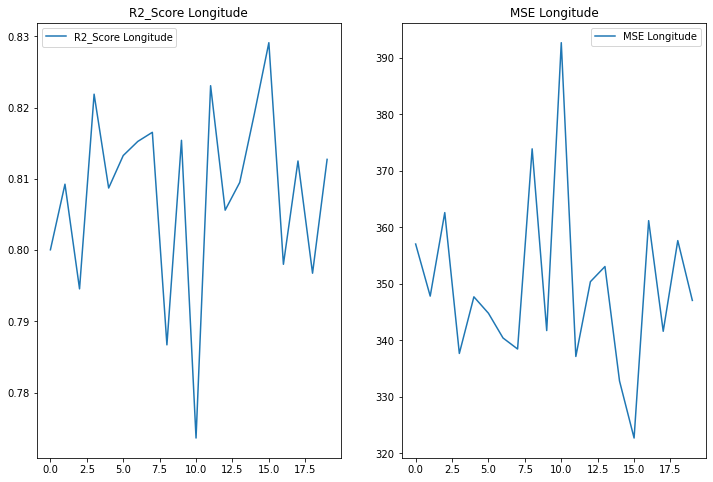

Mean squared errors avg = 333.64083661994584
R2 Score avg = 0.8244366761348806


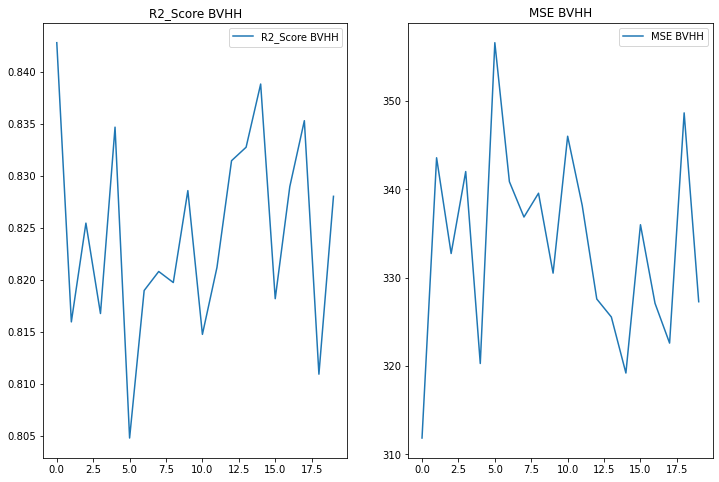

Mean squared errors avg = 346.83571890864374
R2 Score avg = 0.8096745616631884


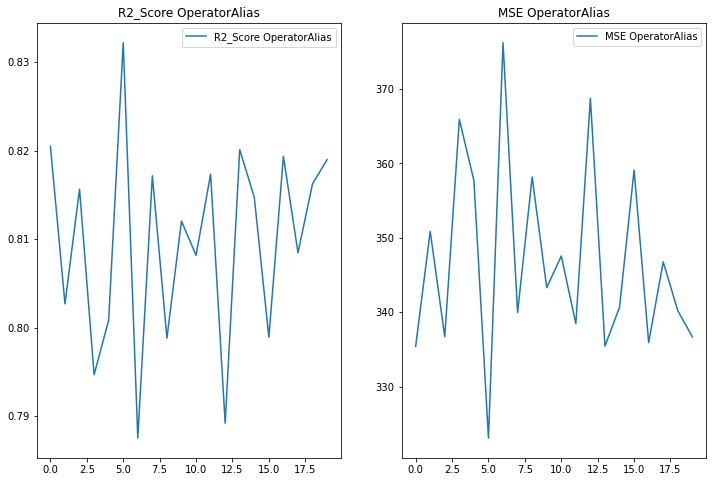

Mean squared errors avg = 342.3776767518309
R2 Score avg = 0.815340455374557


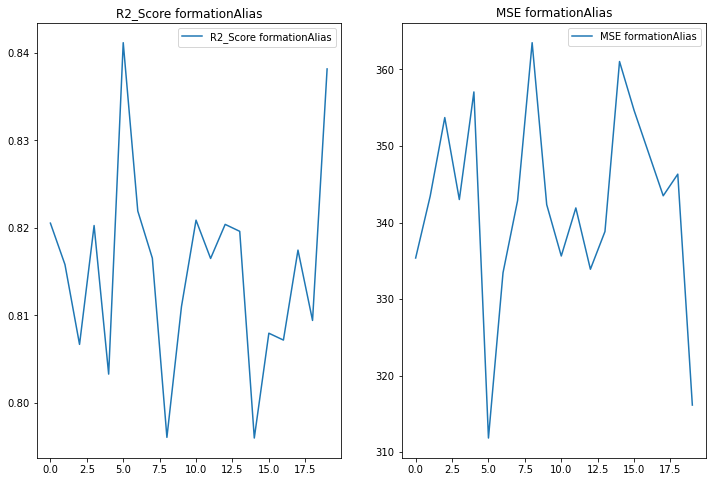

Mean squared errors avg = 335.36413035772404
R2 Score avg = 0.8225989417389578


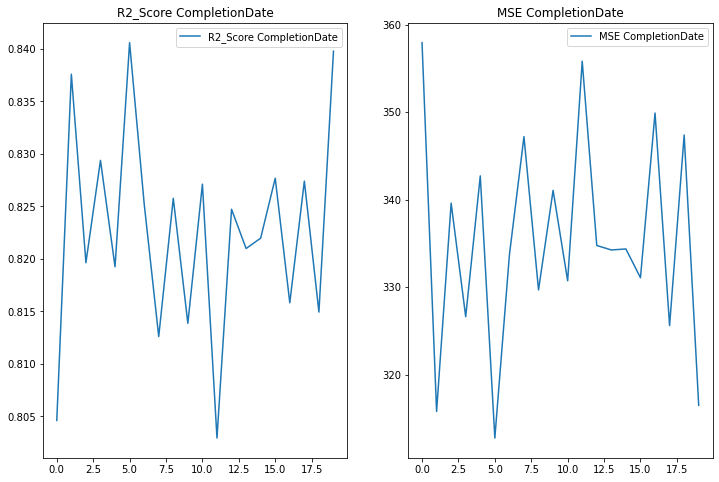

Mean squared errors avg = 334.74004593597715
R2 Score avg = 0.822284980100082


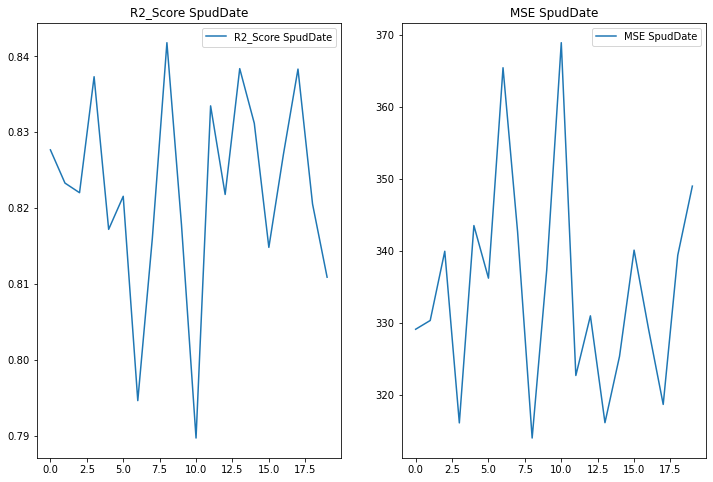

Mean squared errors avg = 330.6869859541438
R2 Score avg = 0.8265894094363231


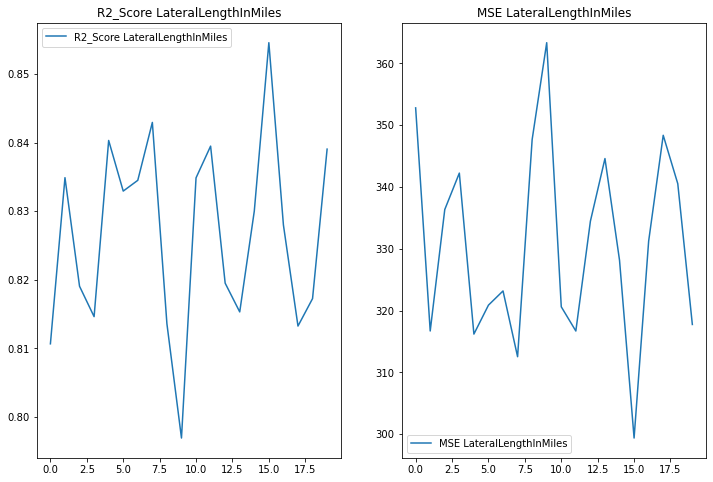

In [14]:

all_cols = ['State', 'Latitude', 'Longitude', 'BVHH', 'OperatorAlias', 'formationAlias', 'CompletionDate', 'SpudDate', 'LateralLengthInMiles']
for i in range(len(all_cols)):
    all_cols_copy = all_cols.copy()
    title_suffix = all_cols_copy[i]
    all_cols_copy.remove(all_cols_copy[i])
    plot_metrics(df, xcolumns=all_cols_copy, ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=20, title_suffix=title_suffix)



Mean squared errors avg = 275.13074545074346
R2 Score avg = 0.8485805492835446


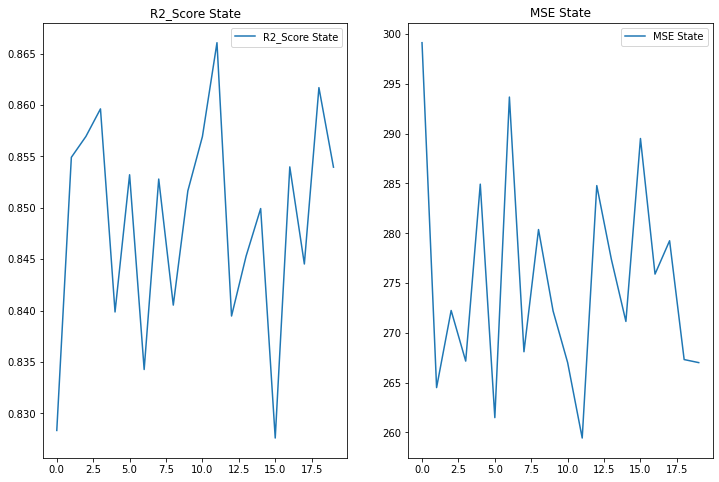

Mean squared errors avg = 279.11116285026725
R2 Score avg = 0.8427986302308828


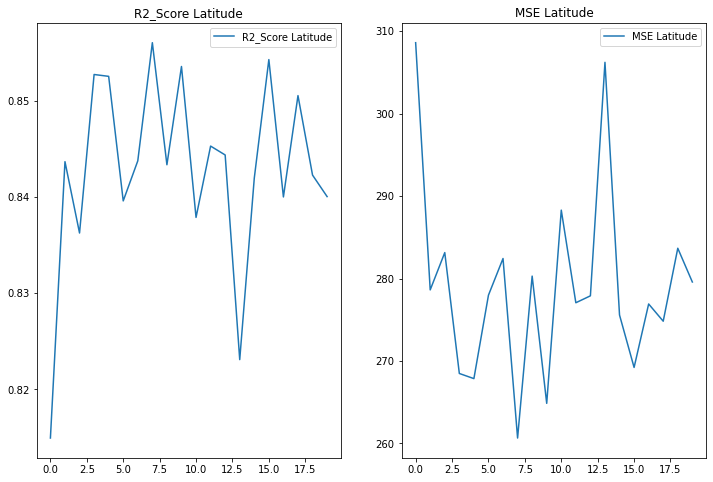

Mean squared errors avg = 279.5184727686654
R2 Score avg = 0.843600838260065


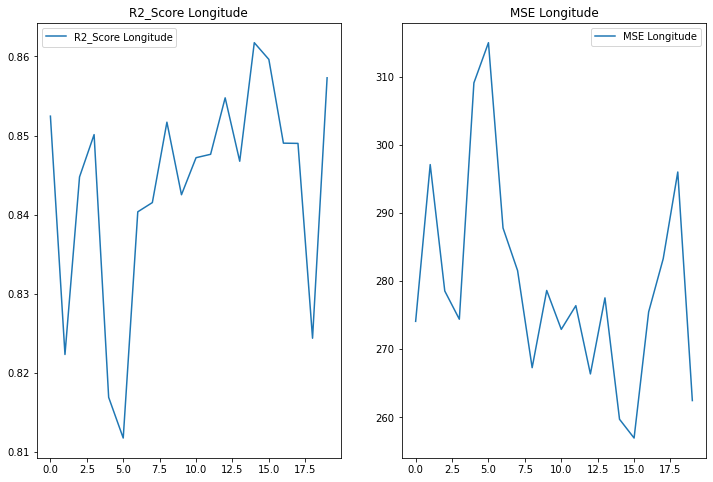

Mean squared errors avg = 277.12408476883
R2 Score avg = 0.8460361963548797


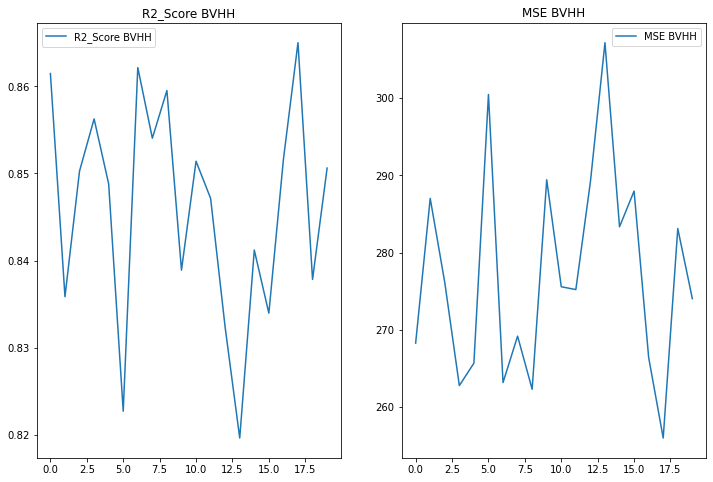

Mean squared errors avg = 291.4793670458024
R2 Score avg = 0.8308819242298785


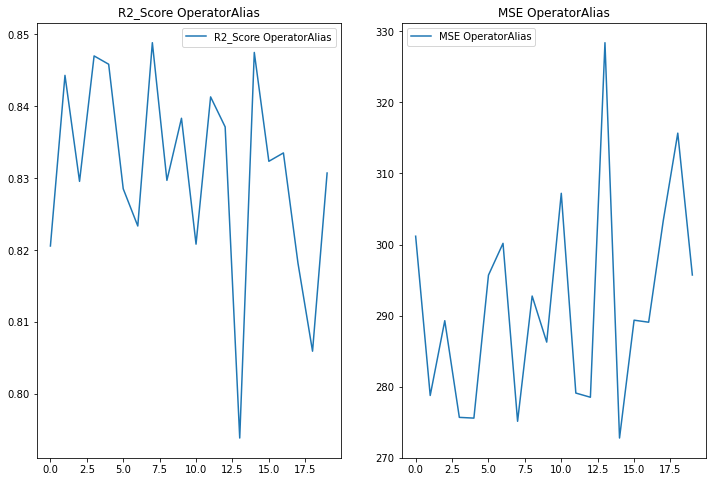

Mean squared errors avg = 280.7136651675949
R2 Score avg = 0.8421786862812372


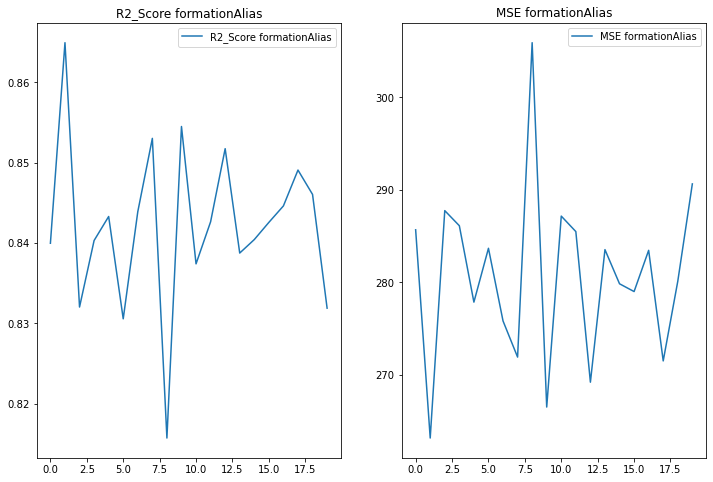

Mean squared errors avg = 282.8309044235515
R2 Score avg = 0.8400435896795895


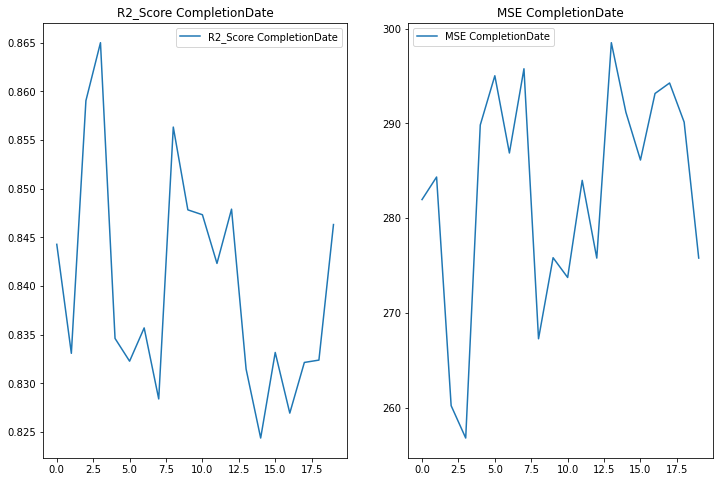

Mean squared errors avg = 275.84058140229024
R2 Score avg = 0.8476075584107908


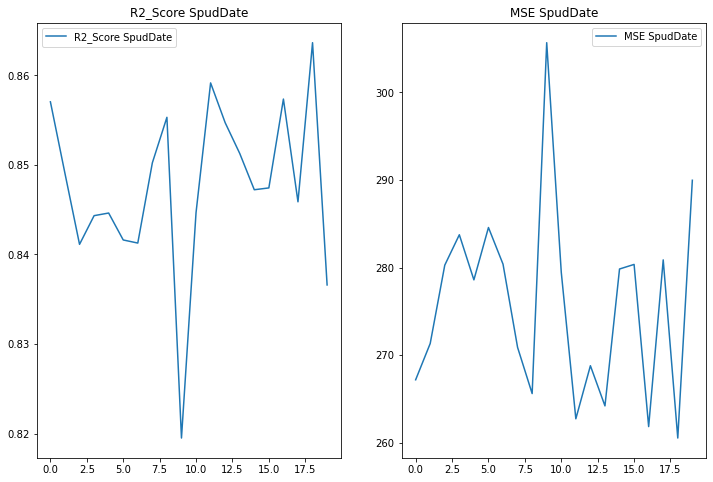

In [7]:

all_cols = ['State', 'Latitude', 'Longitude', 'BVHH', 'OperatorAlias', 'formationAlias', 'CompletionDate', 'SpudDate']
for i in range(len(all_cols)):
    all_cols_copy = all_cols.copy()
    title_suffix = all_cols_copy[i]
    all_cols_copy.remove(all_cols_copy[i])
    plot_metrics(df, xcolumns=all_cols_copy, ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=True, test_size=0.2, runtimes=20, title_suffix=title_suffix)


Mean squared errors avg = 333.7590020016554
R2 Score avg = 0.8234490129654785


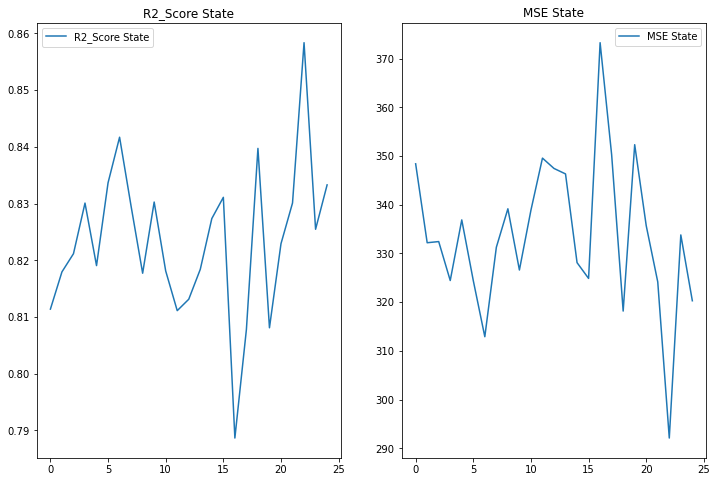

Mean squared errors avg = 352.3859202938751
R2 Score avg = 0.804599114565805


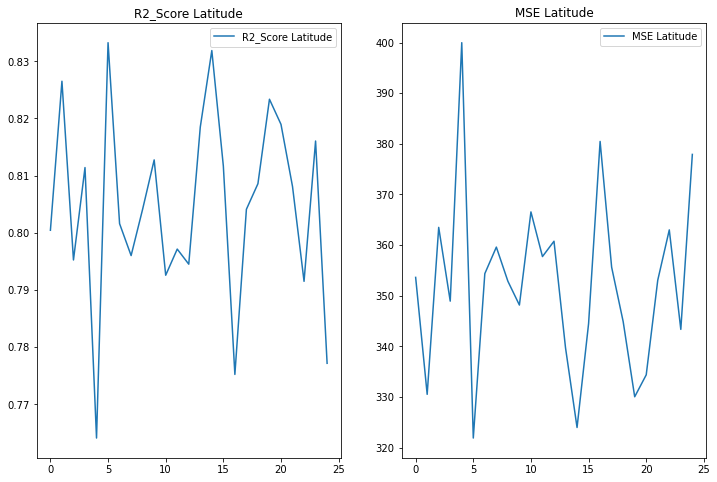

Mean squared errors avg = 353.61801629418363
R2 Score avg = 0.8036555305001705


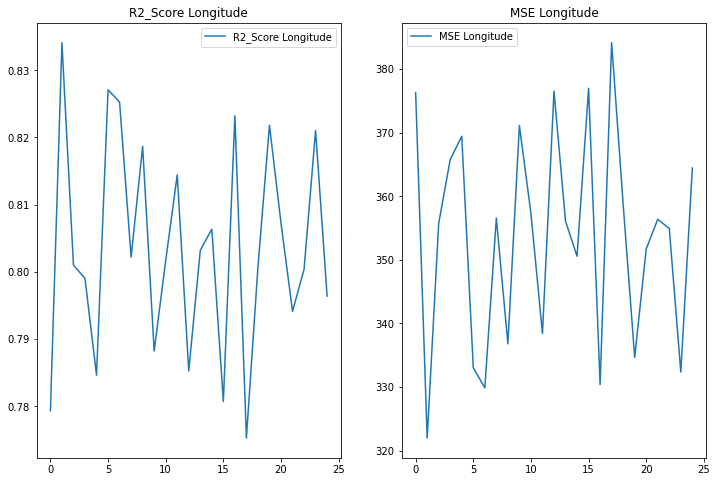

KeyboardInterrupt: 

In [60]:

all_cols = ['State', 'Latitude', 'Longitude', 'OperatorAlias', 'formationAlias', 'CompletionDate', 'SpudDate']
for i in range(len(all_cols)):
    all_cols_copy = all_cols.copy()
    title_suffix = all_cols_copy[i]
    all_cols_copy.remove(all_cols_copy[i])
    plot_metrics(df, xcolumns=all_cols_copy, ycolumn='proppantPerFoot', encoding_type=encodingTypes.one_hot_encoding, normalized=True, test_size=0.15, runtimes=25, title_suffix=title_suffix)
